In [1]:
pwd()

"/home/xlx0727/Scripts/Statistic/qgplsim"

In [2]:
[[0.5, 0.001], [0.5, 1.0], [0.001, 0.5], [1.0, 0.5]] .* 2

4-element Vector{Vector{Float64}}:
 [1.0, 0.002]
 [1.0, 2.0]
 [0.002, 1.0]
 [2.0, 1.0]

# DGP

In [2]:
using DelimitedFiles, Distributions

In [9]:
student_t = StudentizedRange(2, 4)

StudentizedRange{Float64}(ν=2.0, k=4.0)

In [10]:
ϵt = rand(student_t, 10000)

10000-element Vector{Float64}:
  3.597979789938165
  3.54969319195895
  1.5564408719413056
  2.9871760537417775
  1.5702612075927673
  1.4713240568694907
  1.531758424185755
  0.5374031508111166
  4.856515132555273
  1.1463886382318578
  3.820407011188215
  4.191334478526554
  0.8295125083789314
  ⋮
  2.7216024303752797
  1.7094553365533702
  4.0258985664497144
  1.6588917004283081
  0.47473328443318397
  2.6007504715895897
  2.036553256417447
  1.461644737711964
  5.64813107594452
  0.5850625578635363
  1.5203503932945144
 10.190779151110418

In [11]:
filename = "studentized.txt"
open(filename, "a") do io
    writedlm(io, ϵt)
end

In [14]:
et = readdlm(filename, Float64)
size(et)

(12000, 1)

In [15]:
e = rand(et, n)

6000-element Vector{Float64}:
  4.575047142797644
  3.6848878453291003
  1.4426902734647504
  4.209871105904695
  0.5774682553585652
  1.47508605912979
  1.4492245006190492
  4.695030199548825
  3.762500417028904
  4.012531803565649
  0.9054745045662814
  2.154154289028013
  4.284527601874077
  ⋮
 10.812945017834114
  1.6525078329575664
  3.2635142676477127
  1.2218268950158504
  0.4048278192420169
  5.177750852382616
  5.9665998714651405
  1.2367083901430007
  3.3237275896104896
  2.108477846580277
  2.5742790140207097
  1.7305087729367528

# QGPLSIM fitting

In [21]:
# run this ceil if source codes was edited
include("DGP.ji")
# include("qgplsim.ji")
include("qgplsim.ji")
using Statistics, LinearAlgebra, Clustering

α = [-0.5, 1.0, 0.5, 1.5, -2.0] # single index for x, α[1] = c0
θ = [ 0.0, 2.0, 1.0, 1.0, 2.0]  # linear for x, <α, θ> = 0 for identification, θ[1] = c1 := 0
γ = [0.5, 1.0]  * 1.0 # single index for z
# β = [-1.0, 0.5] # linear for z
β = [0.5, -0.5] * 1.0

# Q(y|x, z) = Xθ + Zβ + g(Xα + Zγ)
n_ = 250
n0 = 500
n1 = 750
n2 = 1000
n3 = 1500
n4 = 2000
n5 = 3000
n6 = 4000
n7 = 6000
n8 = 8000
n9 = 12000
n = n2

fx = 2 # y = f(x), fx for different f(x)     
                # fx = 1, y = X*θ + Z*β + (X*α + Z*γ .- 1).^2 + 0.2ϵ
                # fx = 2, y = X*θ + Z*β + log.(1 .+ exp.(X*α + Z*γ .- 1)) + 0.2ϵ

ifz = true # if false, Z = 0, i.e. no category varible
dist = 0 # 0 for gauss, 1 for t
X, Z, y = dgp(n, γ, θ, α, β, fx, dist,  ifz)
# p = length(α)
# q = length(γ)
τ = 0.5
widthExp = -0.17
intercept = 0
# Estimation 

model1 = qgplsim.model(X, Z, y, τ, widthExp, intercept)
alpha_type = 1

# different weight of sum on alpha 
# 0 for true alpha, using α in DGP
# 1 for estimated  ̂α

@time alpha1, gamma, theta, beta = qgplsim.estimator(model1, alpha_type)

println("Estimation of index coefs: ")
println("̂α => ", alpha1)
println("̂γ => ", gamma)

println("Estimation of linear coefs: ")
println("̂θ => ", theta)
println("̂β => ", beta)

# theta * alpha

  4.667328 seconds (16.61 M allocations: 8.206 GiB, 32.85% gc time, 20.32% compilation time)
Estimation of index coefs: 
̂α => [0.37346464151660524, 0.1837973615460778, 0.5366248352822778, -0.7340139491752471]
̂γ => [0.45187866641139546, 0.86606043518884]
Estimation of linear coefs: 
̂θ => [1.9886857713848127 0.9662492866258101 1.0150361089345046 1.9958632592550094]
̂β => [0.24577835991560568, -0.7674420303249602]


In [23]:
alpha1 ./ alpha1[1] |> transpose

1×4 transpose(::Vector{Float64}) with eltype Float64:
 1.0  0.492141  1.43688  -1.96542

In [2]:
using DataFrames, QuantReg, GLM

In [3]:
dft = DataFrame([X y])

formula = Term(:x5) ~ sum([Term(x) for x in [:x1, :x2, :x3, :x4]])

qmodel = QuantRegModel(formula, dft)
QuantReg.fit(qmodel)


x5 ~ 1 + x1 + x2 + x3 + x4, τ=0.5


Degrees of freedom: 1000 total; 995 residual

────────────────────────
             Coefficient
────────────────────────
(Intercept)     1.0866
x1              2.27964
x2              1.53174
x3              1.557
x4              0.411786
────────────────────────

In [4]:
lm(formula, dft)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

x5 ~ 1 + x1 + x2 + x3 + x4

Coefficients:
─────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error       t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────
(Intercept)  1.21613    0.0211369   57.54    <1e-99   1.17465    1.25761
x1           2.28726    0.0210964  108.42    <1e-99   2.24586    2.32866
x2           1.50463    0.0220314   68.29    <1e-99   1.4614     1.54786
x3           1.52847    0.0214012   71.42    <1e-99   1.48648    1.57047
x4           0.438439   0.0205898   21.29    <1e-82   0.398035   0.478843
─────────────────────────────────────────────────────────────────────────

# Paths of $g(x \alpha + z \gamma)$ and $\nabla g$

$\alpha = \hat{\alpha}$,
$z \in S_z$

In [19]:
using LaTeXStrings, Plots

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1342


width = 0.4119526833899339
dy = 2.215826948570721
dx = 3.4408420971255467


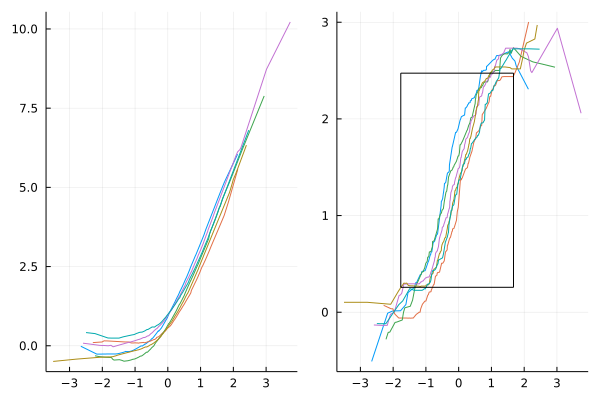

In [24]:
g = zeros(n)
dg = zeros(n)
yz = y - X * transpose(theta)


X = [ones(n, intercept) X]
v = X * alpha1 
categ, index = model1.categ, model1.index
z = collect(index)
ncateg = index.count
width = zeros(ncateg)
v0 = -1e6
v1 = 1e6

for k in 1:ncateg
    vk = v[z[k][2]]
    h = (length(vk))^(-0.17) * var(vk)
    width[k] = h

    dgk(u) = qgplsim.Gz(u, vk, yz[z[k][2]], 1, τ)
    gk(u) = qgplsim.Gz(u, vk, yz[z[k][2]], 0, τ)

    dg[z[k][2]] = dgk(vk)
    g[z[k][2]] = gk(vk)

    vkmin = minimum(vk) + h # + h
    vkmax = maximum(vk) - h# - h

    if  vkmin > v0
        v0 = vkmin
    end
    if  vkmax < v1
        v1 = vkmax
    end  
end

# g, dg = qgplsim.G(v, Z, yz, τ, -0.4) # g: g(v), dg: g'(v)

println("width = ", mean(width))
# v0, v1 = v0 + h, v1 - h
# v0, v1

v_ = v[v .> v1]
_v = v[v .< v0]

v_ = minimum(v_)
_v = maximum(_v)
# _v, v_

C0 = zeros(ncateg)
C1 = zeros(ncateg)
dgf(vv, k) = qgplsim.Gz(vv, v[z[k][2]], yz[z[k][2]], 1, τ)


p1 = plot()
p2 = plot()
for m in 1:ncateg
    C0[m] = dgf(_v, m)[1]
    C1[m] = dgf(v_, m)[1]

    vm = v[index[categ[m]]]
    dgm = dg[index[categ[m]]]
    gm = g[index[categ[m]]]
    indm = sortperm(vm)
    sorted_dgm = dgm[indm]
    sorted_gm = gm[indm]
    sorted_vm = vm[indm]
    plot!(p1, sorted_vm, sorted_gm, label = false ) # L"g_{%$m} (v)")
    plot!(p2, sorted_vm, sorted_dgm, label = false ) # L"\nabla g_{%$m} (v)")

end

c0 = maximum(C0)
c1 = minimum(C1)
println("dy = ", c1 - c0)
println("dx = ", v1 - v0)

plot!(p2, [v0, v0], [c0, c1], color = "black", label = false)
plot!(p2, [v1, v1], [c0, c1], color = "black", label = false)
plot!(p2, [v0, v1], [c0, c0], color = "black", label = false)
plot!(p2, [v0, v1], [c1, c1], color = "black", label = false)


plot(p1, p2, layout = (1,2))

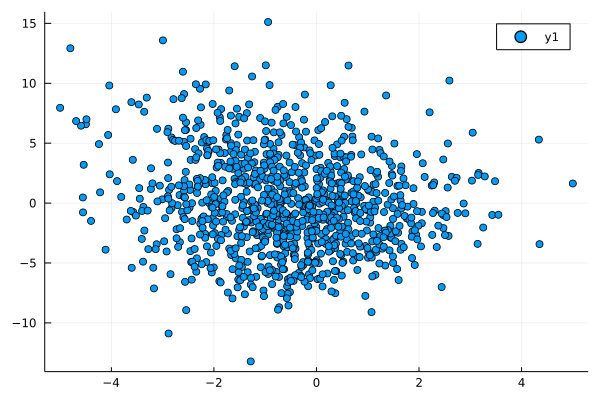

In [98]:
scatter(X[:,2], y)

# Monte Carlo Simulation

In [214]:
Threads.nthreads()

2

In [245]:
include("MonteCarloSIM.ji")

α = [-1.0, 1.0, -0.5] # single index for x
θ = [0.0, 1.0, 2.0]  # linear for x, <α, θ> = 0 for identification
γ = [0.5, 0.5]  # single index for z
# β = [-1.0, 0.5] # linear for z
β = [0.5, -0.5] 
widthExp = -0.17
τ = 0.5
# Q(y|x, z) = Xθ + Zβ + g(Xα + Zγ)
n = 600
fx = 2
dist = 0 # 1 for t
intercept = 0
rep = 200 # MC rept. times

200

## Different Quant

In [82]:
@time Alpha, Gamma, Theta, Beta, Squ = MonteCarlo(n, γ, θ, α, β, 0.1, fx, dist, intercept, rep)

mb_ = mean(Beta, dims = 1)

mt_ = mean(Theta, dims = 1)

ma_ = mean(Alpha, dims = 1)

mg_ = mean(Gamma, dims = 1) 

LoadError: DimensionMismatch("tried to assign 2-element array to 1×202 destination")

In [188]:
@time Alpha, Gamma, Theta, Beta, Squ = MonteCarlo(n, γ, θ, α, β, 0.25, fx, dist, intercept, rep)

mb0 = mean(Beta, dims = 1)

mt0 = mean(Theta, dims = 1)

ma0 = mean(Alpha, dims = 1)

mg0 = mean(Gamma, dims = 1) 

 42.149247 seconds (366.49 M allocations: 143.178 GiB, 22.74% gc time)


1×2 Matrix{Float64}:
 0.360557  0.734407

In [190]:
@time Alpha, Gamma, Theta, Beta, Squ = MonteCarlo(n, γ, θ, α, β, 0.75, fx, dist, intercept, rep)

mb2 = mean(Beta, dims = 1)

mt2 = mean(Theta, dims = 1)

ma2 = mean(Alpha, dims = 1)

mg2 = mean(Gamma, dims = 1) 

 41.438440 seconds (355.91 M allocations: 137.162 GiB, 28.01% gc time)


1×2 Matrix{Float64}:
 0.326819  0.722537

In [191]:
@time Alpha, Gamma, Theta, Beta, Squ = MonteCarlo(n, γ, θ, α, β, 0.9, fx, dist, intercept, rep)

mb3 = mean(Beta, dims = 1)

mt3 = mean(Theta, dims = 1)

ma3 = mean(Alpha, dims = 1)

mg3 = mean(Gamma, dims = 1) 

 44.918757 seconds (403.71 M allocations: 162.037 GiB, 28.08% gc time)


1×2 Matrix{Float64}:
 0.316076  0.676516

## $\tau = 0.5$ 

In [246]:
var1 = var(Gamma, dims = 1)

1×2 Matrix{Float64}:
 0.0229975  0.0107228

In [247]:
@time Alpha, Gamma, Theta, Beta = MonteCarlo(n, γ, θ, α, β, 0.5, fx, dist, widthExp, intercept, rep)

mb1 = mean(Beta, dims = 1)

mt1 = mean(Theta, dims = 1)

ma1 = mean(Alpha, dims = 1)

mg1 = mean(Gamma, dims = 1) 

┌ Warning: The clustering cost increased at iteration #12
└ @ Clustering /Users/kyan/.julia/packages/Clustering/tt9vc/src/kmeans.jl:188


170.348475 seconds (1.61 G allocations: 801.840 GiB, 44.72% gc time, 1.05% compilation time)


1×2 Matrix{Float64}:
 0.507666  0.519257

In [248]:
var1 = var(Gamma, dims = 1)

1×2 Matrix{Float64}:
 0.0203873  0.0103886

In [249]:
ma1

1×2 Matrix{Float64}:
 0.891639  -0.44987

In [250]:
res = [Alpha Gamma]

200×4 Matrix{Float64}:
 0.86931   -0.494268  0.48958   0.559157
 0.884968  -0.465653  0.493043  0.480898
 0.914353  -0.404918  0.424556  0.481573
 0.865462  -0.500974  0.539339  0.595005
 0.897594  -0.440824  0.409617  0.322478
 0.841328  -0.540526  0.384981  0.503112
 0.88695   -0.461865  0.511109  0.566723
 0.881855  -0.47152   0.375461  0.557785
 0.898203  -0.439581  0.261975  0.536219
 0.891867  -0.452299  0.667159  0.735156
 0.9146    -0.404359  0.647753  0.517927
 0.858714  -0.512455  0.514682  0.491304
 0.850973  -0.525209  0.509315  0.558023
 ⋮                              
 0.908207  -0.418522  0.483328  0.574523
 0.835004  -0.550244  0.553161  0.411697
 0.888035  -0.459775  0.61659   0.61078
 0.803855  -0.594826  0.409133  0.539194
 0.895748  -0.444563  0.62101   0.602265
 0.894562  -0.446943  0.48338   0.449511
 0.890153  -0.455661  0.521153  0.577759
 0.877224  -0.480082  0.509971  0.512827
 0.873667  -0.486525  0.390355  0.644249
 0.899077  -0.43779   0.609798  0.623151
 0

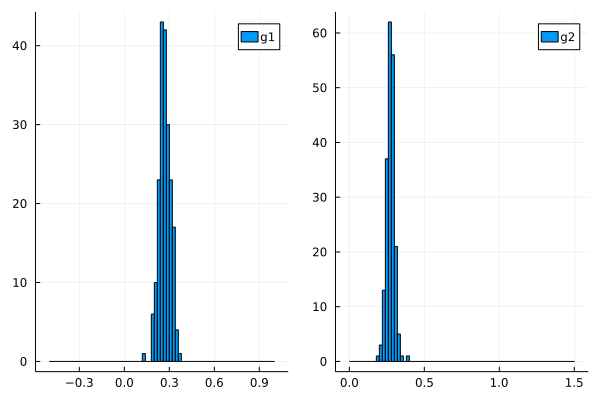

In [159]:
p1 = histogram(Gamma[:,1], bins = -0.5:0.02:1, label = "g1")
p2 = histogram(Gamma[:,2], bins = 0:0.02:1.5, label = "g2")
plot(p1, p2, layout = (1, 2))

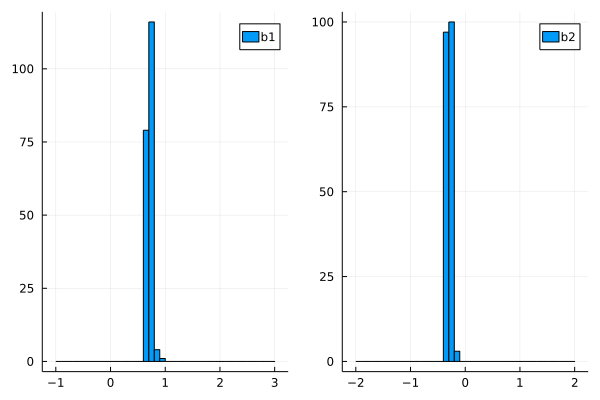

In [147]:

p1 = histogram(Beta[:,1], bins = -1:0.1:3, label = "b1")
p2 = histogram(Beta[:,2], bins = -2:0.1:2, label = "b2")
plot(p1, p2, layout = (1, 2))

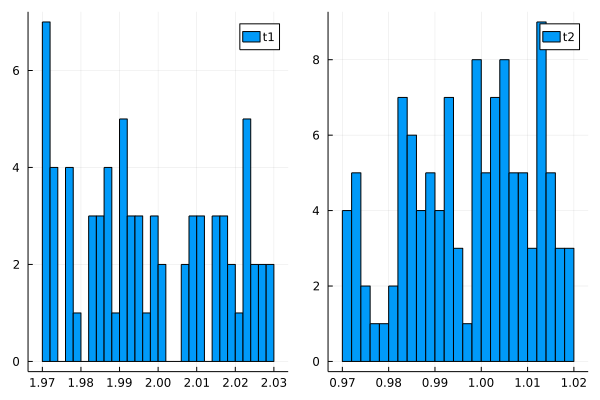

In [14]:
p1 = histogram(Theta[:,1], bins = 1.97:0.002:2.03, label = "t1")
p2 = histogram(Theta[:,2], bins = 0.97:0.002:1.02, label = "t2")
plot(p1, p2, layout = (1, 2))

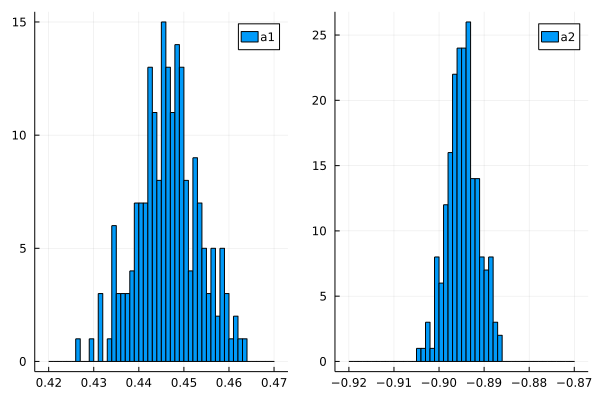

In [16]:
p1 = histogram(Alpha[:,1], bins = 0.42:0.001:0.47, label = "a1")
p2 = histogram(Alpha[:,2], bins = -0.92:0.001:-0.87, label = "a2")
plot(p1, p2, layout = (1, 2))

In [79]:
filename = "./simulations/records/250 f2 d1 1.0 0.5.mat"

"./simulations/records/250 f2 d1 1.0 0.5.mat"

In [80]:
using MAT, Statistics

In [81]:
d = matread(filename)
g = d["Gamma"]
a = d["Alpha"]
ma = mean(a, dims = 1)

1×2 Matrix{Float64}:
 0.428657  0.606587

In [82]:
mg = mean(g, dims = 1)

1×2 Matrix{Float64}:
 0.275254  0.126393

In [83]:
mg * 1.6

1×2 Matrix{Float64}:
 0.440406  0.202228

# Postprocess

In [9]:
using MAT
filename = "a=[-1,1,-2]/records/"

"a=[-1,1,-2]/records/"